### Package version
- tensorflow==2.2.0rc3
- numpy==1.18.2
- matplotlib==3.2.1
- google==2.0.3
- segmentation_models==1.0.1

# U - Net
## Problem: 

Seismic data is collected using reflection seismology, or seismic reflection. The method requires a controlled seismic source of energy, such as compressed air or a seismic vibrator, and sensors record the reflection from rock interfaces within the subsurface. The recorded data is then processed to create a 3D view of earth’s interior. Reflection seismology is similar to X-ray, sonar and echolocation.

A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. In theory, the strength of reflection is directly proportional to the difference in the physical properties on either sides of the interface. While seismic images show rock boundaries, they don't say much about the rock themselves; some rocks are easy to identify while some are difficult.

There are several areas of the world where there are vast quantities of salt in the subsurface. One of the challenges of seismic imaging is to identify the part of subsurface which is salt. Salt has characteristics that makes it both simple and hard to identify. Salt density is usually 2.14 g/cc which is lower than most surrounding rocks. The seismic velocity of salt is 4.5 km/sec, which is usually faster than its surrounding rocks. This difference creates a sharp reflection at the salt-sediment interface. Usually salt is an amorphous rock without much internal structure. This means that there is typically not much reflectivity inside the salt, unless there are sediments trapped inside it. The unusually high seismic velocity of salt can create problems with seismic imaging.

### Data
The data is a set of images chosen at various locations chosen at random in the subsurface. The images are 101 x 101 pixels and each pixel is classified as either salt or sediment. In addition to the seismic images, the depth of the imaged location is provided for each image. The goal of the competition is to segment regions that contain salt.

#### Source: 
https://www.kaggle.com/c/tgs-salt-identification-challenge


### Note: 
Accept the terms and download data from the above link

### Aim: 

Implement U-Net neural model architecture in keras to solve this problem.


In this, you are asked to segment salt deposits beneath the Earth’s surface. Given a set of seismic images that are 101 x 101 pixels each and each pixel we need to classify as either salt or sediment. Our goal is to segment regions that contain salt. A seismic image is produced from imaging the reflection coming from rock boundaries. The seismic image shows the boundaries between different rock types. 

### Broad Steps:

- Download the dataset
- Upload to Drive
- Import from drive to colab
- Load the images and create training data.
- Build U-net Model
- Train your model.
- Check the validation accuracy and plot sample.

In [42]:
import tensorflow
tensorflow.__version__

'2.2.0-rc3'

In [43]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Extract data

In [0]:
#For simplicity we have added the required code here.
from zipfile import ZipFile

with ZipFile('/content/drive/My Drive/train.zip', 'r') as zf:
  zf.extractall()

####  The train file have both images and masks with the same names_ids.

### Get the list of names of images and masks and name the list imagelist and masklist.

Hint - Use os.listdir() funtions.

In [0]:
imagelist = os.listdir('train/images')
masklist = os.listdir('train/masks')

In [49]:
#Test your list names by printing some of the names as given below.
print(imagelist[-1])
print(masklist[-1])
print(imagelist[10])
print(masklist[10])

7c6221dbb8.png
7c6221dbb8.png
1befe1ba44.png
1befe1ba44.png


### Read and test your images and respective masks.

Hint -

import  matplotlib.pyplot as plt

import cv2

plt.imshow(cv2.imread('path of image'))

plt.imshow(cv2.imread('path of mask'))


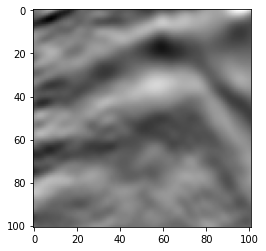

In [51]:
import  matplotlib.pyplot as plt
import cv2

plt.imshow(cv2.imread('train/images/{}'.format(imagelist[10])))

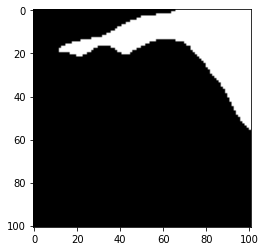

In [50]:
plt.imshow(cv2.imread('train/masks/{}'.format(masklist[10])))

### Create your training data.

Hints - 

image_path = os.path.join('path of your image directory' +n )

mask_path = os.path.join('path of your mask directory'+n )

In [66]:
im_height

128

In [52]:
import numpy as np

im_height, im_width = 128

# Get and resize train images and masks
def get_data(train=True):
    #ids = next(os.walk("train/images"))[2]
    X = np.zeros((len(imagelist), im_height, im_width, 1), dtype=np.float32)
    y = np.zeros((len(masklist), im_height, im_width, 1), dtype=np.float32)
    for n in imagelist:
        k = imagelist.index(n)
        image_path = os.path.join('train/images/' +n )
        mask_path = os.path.join('train/masks/' +n )
        
        # Load images
        img = cv2.imread(image_path, 0)
        resized_img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)
        

        # Load masks
        if train:
            mask = cv2.imread(mask_path, 0)
            resized_mask = cv2.resize(mask, (128, 128), interpolation = cv2.INTER_AREA)
            resized_mask = np.reshape(resized_mask, (128,128,1))
            
           

        # Save images
        X[k, ..., 0] = resized_img.squeeze() / 255
        if train:
            y[k] = resized_mask/255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(train=True)

Done!


In [0]:
# Split train and valid
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=0)

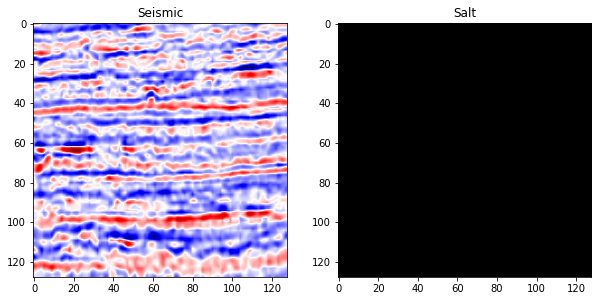

In [54]:
## Test your data whether it looks fine - Random check
import random 
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');

### Define loss and dice_coeff function.

In [0]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

def loss(y_true, y_pred):
    return tensorflow.keras.backend.binary_crossentropy(y_true, y_pred) - tensorflow.math.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

### Build and compile UNet Model for your data.

Hint - 
You can install and use segmentation models from this github repository.

#### Install segmentation models

!pip install git+https://github.com/qubvel/segmentation_models

In [56]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-8d7im98k
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-8d7im98k
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp36-none-any.whl size=33792 sha256=b785d1e6bc55500bb6d9d2e6c87a45a742d938c23c4af268c2f71383036bf348
  Stored in directory: /tmp/pip-ephem-wheel-cache-93x6z4px/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [0]:
from segmentation_models import Unet

model = Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(None, None, 1))

In [0]:
model.compile(optimizer='Adam', loss=loss, metrics=[dice_coefficient])

In [59]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, None, None, 1 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 1 3           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_35 (ZeroPadding2 (None, None, None, 1 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 3136        zero_padding2d_35[0][0]          
____________________________________________________________________________________________

In [0]:
from segmentation_models import get_preprocessing

BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)
X_train = preprocess_input(X_train)
X_valid = preprocess_input(X_valid)

### Fit your model using model.fit function.
Hint - As it might take long time to run. Run it for only 1 or 2 epochs.

In [61]:
model.fit(
    x=X_train,
    y=y_train,
    batch_size=16,   
    epochs=1,
    validation_data=(X_valid, y_valid)
    )

Train on 3400 samples, validate on 600 samples
Epoch 1/1
3400/3400 [==============================] - 1320s 388ms/step - loss: 0.9937 - dice_coefficient: 0.5867 - val_loss: 2.8705 - val_dice_coefficient: 0.4439


### Predict on val set using model.predict funtion and store in preds_val variable.



In [62]:
preds_val = model.predict(X_valid, verbose=1)

600/600 [==============================] - 53s 88ms/step


In [0]:
#Get the threshold predictions to look at refined results.
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [0]:
#Plot a sample
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

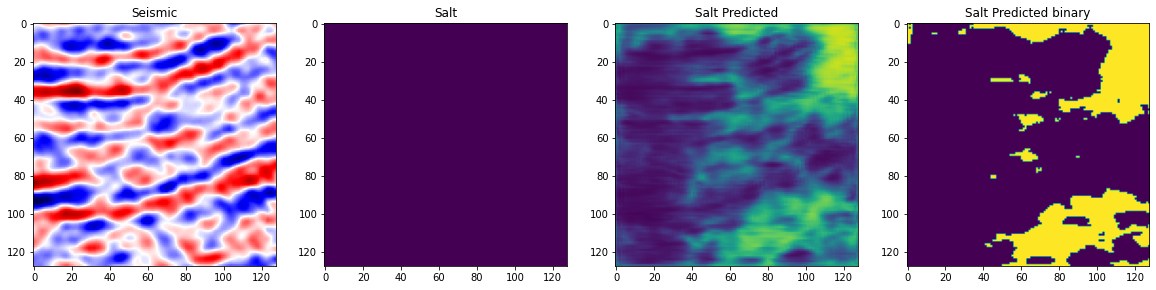

In [65]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=15)

If you are getting good results- Congratulations.
If you are not, try to explore what might be the reason.